I will be categorizing images of Pokemons. Since logistic regression is a linear classifier, I chose to develop a model that determines between two classes. For this exercise, I will be classifying Ditto and Pikachu. I will extract two features, represented by a single value, from all images and use these features to classify.

The dataset link is here: https://www.kaggle.com/datasets/unexpectedscepticism/11945-pokemon-from-first-gen

The dataset contains square images of various dimensions. My first step would therefore to convert all images to RGB and resize it to 32x32x3.

The data is then visualized by producing a 2D scatter plot where red and blue are used to distinguish the two classes. It is also generated after training to visualize the discriminating line.

In [794]:
import os
import numpy as np
from PIL import Image
import time
import matplotlib.pyplot as plt

In [795]:
"""
VISUALIZATION CODE
"""

def plot_discriminating_function_old(f, range=None):
    # Create a meshgrid
    if range is None:
        range = [[0,1],[0,1]]
    x = np.linspace(*range[0], 400)
    y = np.linspace(*range[1], 400)
    X, Y = np.meshgrid(x, y)

    Z = f(X, Y)
    plt.contourf(X, Y, Z, levels=[-10000, 0], colors=[(0.8, 0.2, 0.2, 0.36)])  # red fill for 5
    plt.contourf(X, Y, Z, levels=[0, 10000], colors=[(0.3, 0.3, 0.6, 0.36)])  # blue fill for 1

def plot_discriminating_function(f, data_variable, data_constant, plot_range=None):
    # Create a meshgrid
    if plot_range is None:
        plot_range = [[0,1],[0,1]]
    x = np.linspace(*plot_range[0], 400)
    y = np.linspace(*plot_range[1], 400)

    X, Y = np.meshgrid(x, y)

    X_flat = X.flatten()
    Y_flat = Y.flatten()
    data = np.zeros((len(X_flat), len(data_constant)))
    for i in range(len(data_constant)):
        data[:, i] = data_constant[i]
    data[:, 0] = 1
    data[:, data_variable[0]] = X_flat
    data[:, data_variable[1]] = Y_flat

    Z = f(data)
    Z = Z.reshape(X.shape)

    plt.contourf(X, Y, Z, levels=[-10000, 0], colors=[(0.8, 0.2, 0.2, 0.36)])  # red fill for 5
    plt.contourf(X, Y, Z, levels=[0, 10000], colors=[(0.3, 0.3, 0.6, 0.36)])  # blue fill for 1

def plot_points(x, y):
    colors = ['blue' if value == 1 else 'red' for value in y]
    plt.scatter(x[:, 0], x[:, 1], color=colors, marker='x', s = 1)

In [796]:
"""
PREPROCESSING HELPER FUNCTION

formats image files and converts into numpy arrays of the same shape, then saves to specified location

Returns 0 upon success, otherwise returns 1 (unsuccessful may be due to undesirable properties such as
large aspect ratio)
"""

def process_file(file_path, processed_file_path, target_size = 32, aspect_ratio_thres = 1.3):
    with Image.open(file_path) as image:
        # crop out the longer dimension so it's square
        width, height = image.size
        new_size = min(width, height)
        if new_size * aspect_ratio_thres < max(width, height):
            # print(f'skipped due to aspect ratio too high')
            return 1
        left = (width - new_size) / 2
        top = (height - new_size) / 2
        right = (width + new_size) / 2
        bottom = (height + new_size) / 2
        image = image.crop((left, top, right, bottom))
        
        # resize
        image = image.resize((target_size, target_size))

        # convert the image to RGB
        image = image.convert('RGB')
        
        # convert to numpy array
        img_array = np.array(image)

        # print(f'processed array shape: {img_array.shape}')
        if img_array.shape != (target_size, target_size, 3):
            print(f'error! wrong shape {img_array.shape}')
        
        # save to file
        np.save(processed_file_path, img_array)
        return 0

In [797]:
def feature_variation1(data):
    variance = np.var(data, axis=0)
    return np.sum(variance)

def feature_variation2(data):
    variance = np.var(data, axis=1)
    return np.sum(variance)

def feature_luminosity_variation1(data):
    lum = np.mean(data, axis=0)
    variance = np.var(lum, axis=0)
    return np.sum(variance)

def feature_luminosity_variation2(data):
    lum = np.mean(data, axis=1)
    variance = np.var(lum, axis=0)
    return np.sum(variance)

def feature_luminosity_variation3(data):
    lum = np.mean(data, axis=2)
    variance = np.var(lum, axis=0)
    return np.sum(variance)


def get_conv_function(filter):
    return lambda row : np.convolve(row, filter, 'same')

def thresholding(data):

    randint = int(np.random.random() * 100)

    if randint == 0:
        plt.imshow(data, interpolation='nearest')
        plt.show()

    filter = [-1,-0.2,0,0.2,1]
    result = np.apply_along_axis(get_conv_function(filter), 0, data)
    threshold = 30
    result = np.where(result < threshold, 0, 255)

    if randint == 0:
        plt.imshow(result, interpolation='nearest')
        plt.show()
        time.sleep(1)

    return np.sum(result)



In [798]:
"""
FEATURE EXTRACTION HELPER FUNCTION

One of the feature extraction methods

Extracts exactly 5 features for every data point and returns them as 1D numpy array
"""

def extract_5_features(data):
    features = np.ones((5,))
    features[0] = thresholding(data)
    features[1] = feature_variation2(data)
    features[2] = feature_luminosity_variation1(data)
    features[3] = feature_luminosity_variation2(data)
    features[4] = feature_luminosity_variation3(data)
    return features


def extract_3_features(data):
    features = np.ones((3,))
    features[1] = feature_variation2(data)
    #features[1] = feature_luminosity_variation1(data)
    features[2] = feature_luminosity_variation3(data)
    return features


In [799]:
"""
MAIN PIPELINE 1

preprocesses data by reading from directory and saves processed data into another directory with same structure.
"""

def preprocess(raw_data_dir, processed_data_dir):
    # Create the processed_data directory if it doesn't exist
    if not os.path.exists(processed_data_dir):
        os.makedirs(processed_data_dir)

    # List all subfolders in raw_data
    for subdir in os.listdir(raw_data_dir):
        print(f'reading directory {subdir}')
        raw_subdir_path = os.path.join(raw_data_dir, subdir)
        
        # Check if it's a directory
        if not os.path.isdir(raw_subdir_path):
            continue
        processed_subdir_path = os.path.join(processed_data_dir, subdir)
        
        # Create the subfolder in processed_data if it doesn't exist
        if not os.path.exists(processed_subdir_path):
            os.makedirs(processed_subdir_path)
        
        count = 0
        processed_count = 0
        total = len(os.listdir(raw_subdir_path))
        # Process each file in the subdirectory
        for filename in os.listdir(raw_subdir_path):
            file_path = os.path.join(raw_subdir_path, filename)
            processed_file_path = os.path.join(processed_subdir_path, filename)
            
            # Process the file
            return_code = process_file(file_path, processed_file_path)
            count += 1
            if return_code == 0:
                processed_count += 1
            if count % 100 == 0 or count == total:
                print(f'traversed {count} / {total}, processed {processed_count}')
                
    print('finished preprocessing')

In [800]:
"""
MAIN PIPELINE 2

extracts features from processed data and returns them as two numpy arrays, X and Y
where X are the features for each data point and Y is their labels
"""

def import_features(processed_data_dir, features, features_extraction_function, folders=None, binary=False):
    total_items = 0
    # List all subfolders
    for subdir in os.listdir(processed_data_dir):
        if folders is not None and subdir not in folders:
            continue
        subdir_path = os.path.join(processed_data_dir, subdir)
        
        # Check if it's a directory
        if not os.path.isdir(subdir_path):
            continue
        total_items += len(os.listdir(subdir_path))
    print(f'found {total_items} items!')
        

    X = np.zeros((total_items, features))
    Y = np.zeros((total_items, 1))
    
    category_counter = 0
    item_counter = 0

    if binary: category_counter = -1

    # List all subfolders
    for subdir in os.listdir(processed_data_dir):
        if folders is not None and subdir not in folders:
            continue
        print(f'reading directory {subdir}')
        subdir_path = os.path.join(processed_data_dir, subdir)
        
        # Check if it's a directory
        if not os.path.isdir(subdir_path):
            continue
        
        # Process each file in the subdirectory
        for filename in os.listdir(subdir_path):
            file_path = os.path.join(subdir_path, filename)
            data = np.load(file_path)
            features = features_extraction_function(data)
            
            X[item_counter] = features
            Y[item_counter][0] = category_counter
            item_counter += 1

            if item_counter % 100 == 0:
                print(f'processed {item_counter}/{len(os.listdir(subdir_path))}')

        category_counter += 1
        if binary: category_counter += 1

    print(f'label statistics: class -1 {np.sum(Y == -1)}, class 1 {np.sum(Y == 1)}')

    num_test = int(item_counter/8)
    test_indices = np.random.choice(item_counter, num_test, replace=False)
    Xtest = X[test_indices, :]
    Ytest = Y[test_indices, :]

    X = np.delete(X, test_indices, axis=0)
    Y = np.delete(Y, test_indices, axis=0)

    print('finished feature import')
    return X, Y, Xtest, Ytest

Two logistic regression methods are implemented: regular logistic regression that performs gradient descent on all data at the same time, and stochastic gradient descent that performs gradient descent on only one data point at a time.

In both cases, the general formula for accomplishing this is X * sigmoid (X * weights) - Y
The loss function is 1/(1 + e^-x)

Additionally, momentum is implemented as an optimzation method for both cases, and learning rate is decreased over time.

In [801]:
"""
MAIN PIPELINE LEARNING: LOGISTIC REGRESSION

all the functions for computing the logistic regression.
"""

def sigmoid(x):
    e = 1e-6
    return np.clip(1/(1 + np.exp(-x)), e, 1 - e)

def logistic_loss(x, y, w):
    h = sigmoid(x @ w)
    return (-1 / len(x)) * (y.T @ np.log(h) + (1 - y).T @ np.log(1 - h))

def logistic_optimize(x, y, a, iters=10000, momentum=0.8):
    m, n = x.shape
    w = np.random.randn(n, 1)
    print_interval = int(iters/10)
    last_gradient = w

    for i in range(iters):
        if i % print_interval == 0:
            print(f'iteration {i} / {iters}')
            incorrect = np.sum(test(x, y, w))
            print(f'accuracy: {(len(x) - incorrect) / len(x)}')
            a *= 0.9

        gradient = (1 - momentum) * (1/m) * x.T @ (sigmoid(x @ w) - y) + momentum * last_gradient
        last_gradient = gradient
        w -= a * gradient

    return np.reshape(w, (n,))

def logistic_sto_optimize(x, y, a, epoch=100, momentum=0.8):
    m, n = x.shape
    w = np.random.randn(n, 1)
    x_reshaped = np.reshape(x, (m, n, 1))
    learning_rate_decay_interval = int(epoch/10)
    last_gradient = w

    for e in range(epoch):
        if e % learning_rate_decay_interval == 0:
            print(f'iteration {e} / {epoch}')
            incorrect = np.sum(test(x, y, w))
            print(f'accuracy: {(len(x) - incorrect) / len(x)}')
            a *= 0.8

        for i in range(len(x_reshaped)):
            xi = x_reshaped[i, :]
            yi = y[i]
            gradient = (1 - momentum) * (sigmoid(xi.T @ w) - yi) * xi + momentum * last_gradient
            last_gradient = gradient
            w -= a * gradient

    return np.reshape(w, (n,))

def test(x, y, w):
    results = np.sign(np.matmul(x, w))
    stacked = np.column_stack((y, results))
    comparison =  np.abs(0.5 * (stacked[:, 0] - stacked[:, 1]))
    return comparison


def evaluate(data, w):
    results = np.sign(np.matmul(data, w))
    return results

def get_f(w):
    return lambda x: evaluate(x, w)

found 159 items!
reading directory Ditto
reading directory Pikachu
processed 100/103
label statistics: class -1 56, class 1 103
finished feature import
X shape: (140, 3)
Y Shape: (140, 1)
X test shape: (19, 3)
Y test Shape: (19, 1)
scatter plot of the two selected classes in different colors


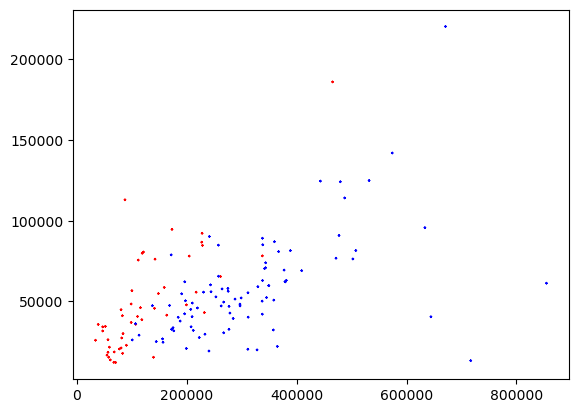

iteration 0 / 100
accuracy: 0.6428571428571429
iteration 10 / 100
accuracy: 0.7357142857142858
iteration 20 / 100
accuracy: 0.8214285714285714
iteration 30 / 100
accuracy: 0.7857142857142857
iteration 40 / 100
accuracy: 0.7785714285714286
iteration 50 / 100
accuracy: 0.7857142857142857
iteration 60 / 100
accuracy: 0.7857142857142857
iteration 70 / 100
accuracy: 0.7857142857142857
iteration 80 / 100
accuracy: 0.7857142857142857
iteration 90 / 100
accuracy: 0.7857142857142857


C:\Users\eggyr\AppData\Local\Temp\ipykernel_24380\3647475528.py:9: RuntimeWarning: overflow encountered in exp
  return np.clip(1/(1 + np.exp(-x)), e, 1 - e)


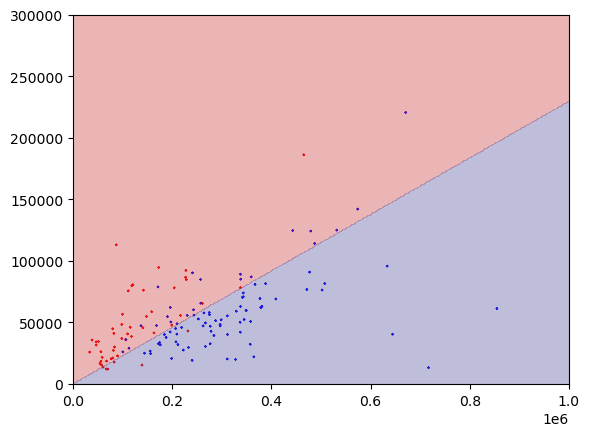

test accuracy: 0.8421052631578947


In [802]:
"""
RUNNER
"""

# directory containing original images
raw_data_dir = '../../Data/pokemon/PokemonData'

# directory to save processed numpy arrays
processed_data_dir = '../../Data/pokemon/PokemonDataProcessed'

# specifies which categories to read from. Leave as None to read from all
folders = ['Pikachu','Ditto']

# !!!!!!!!!!!!!!!!!!! UNCOMMENT BELOW TO ENABLE PREPROCESSING
#preprocess(raw_data_dir, processed_data_dir)

# category map represents the mapping for storing categories as an integer rather than having to use their original string
X, Y, Xtest, Ytest = import_features(processed_data_dir, 3, extract_3_features, folders, True)
print(f'X shape: {X.shape}\nY Shape: {Y.shape}')
print(f'X test shape: {Xtest.shape}\nY test Shape: {Ytest.shape}')

# visualization
print(f'scatter plot of the two selected classes in different colors')
plot_points(X[:, [1, 2]], Y)
plt.show()

weights = logistic_optimize(X, Y, 0.5, 100)

offset = None

if offset is None:
    offset = [1] * X.shape[1]

bounds = [[-10,1000000], [-100,300000]]

plot_points(X[:, [1, 2]], Y)
plot_discriminating_function(get_f(weights), [1,2], offset, bounds)
plt.show()

'''
plot_points(X[:, [1, 3]], Y)
plot_discriminating_function(get_f(weights), [1,3], offset, bounds)
plt.show()

plot_points(X[:, [2, 3]], Y)
plot_discriminating_function(get_f(weights), [2,3], offset, bounds)
plt.show()

plot_points(X[:, [2, 4]], Y)
plot_discriminating_function(get_f(weights), [2,4], offset, bounds)
plt.show()
'''

print(f'test accuracy: {(len(Xtest) - np.sum(test(Xtest, Ytest, weights))) / len(Xtest)}')




Accuracy without gradient descent optimization methods:

iteration 0: 0.36428571428571427

iteration 10: 0.45714285714285713

iteration 20: 0.7285714285714285

iteration 30: 0.42857142857142855

iteration 40: 0.6428571428571429

iteration 50: 0.6214285714285714

iteration 60: 0.6428571428571429

iteration 70: 0.7285714285714285

iteration 80: 0.7857142857142857

iteration 90: 0.7928571428571428

Testing: 0.7928571428571428

-------------------------------------------------------------

Accuracy with momentum and learning rate decay: 

iteration 0: 0.55

iteration 10: 0.5357142857142857

iteration 20: 0.6428571428571429

iteration 30: 0.7785714285714286

iteration 40: 0.7857142857142857

iteration 50: 0.7857142857142857

iteration 60: 0.7857142857142857

iteration 70: 0.7857142857142857

iteration 80: 0.7785714285714286

iteration 90: 0.7857142857142857

Testing: 0.8421052631578947

-------------------------------------------------------------

The optimization methods should be used as they lead to faster convergence and a better final accuracy, as observed in the above results.